# Imports

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from ForexEnv_RQ5 import ForexEnv
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

from common.constants import DEVICE, SEED
from common.data import ForexData, combine_df

# Loading data

In [28]:
bid_path = 'D:\\Facultate\\Y3\\Q4\\TUD-CSE-RP-RLinFinance\\RQ5\\data\\forex\\EURUSD\\15M\\BID\\10.05.2022T00.00-10.05.2025T23.45.csv'
ask_path = 'D:\\Facultate\\Y3\\Q4\\TUD-CSE-RP-RLinFinance\\RQ5\\data\\forex\\EURUSD\\15M\\ASK\\10.05.2022T00.00-10.05.2025T23.45.csv'

ask_df = ForexData(ask_path).df
bid_df = ForexData(bid_path).df
forex_data = combine_df(bid_df, ask_df)

# Train / test split

In [29]:
train_split = 0.8
split_idx = int(len(forex_data) * train_split)
train_df = forex_data.iloc[:split_idx]
test_df = forex_data.iloc[split_idx:]

print("Train samples:", len(train_df))
print("Test samples:", len(test_df))

Train samples: 41176
Test samples: 10295


# Environment setup

In [30]:
def make_env(df, seed=None):
    def _init():
        env = ForexEnv(df.copy(), log_level=0, seed=seed)
        return env
    return _init

In [31]:
NUM_ENVS = 4

train_env = SubprocVecEnv([make_env(train_df, seed=i) for i in range(NUM_ENVS)])
test_env = SubprocVecEnv([make_env(test_df, seed=100 + i) for i in range(NUM_ENVS)])


# DQN Model

In [32]:
policy_kwargs = dict(net_arch=[128, 128])

model = DQN(
    policy="MlpPolicy",
    env=train_env,
    learning_rate=0.001,
    buffer_size=50000,
    learning_starts=1000,
    batch_size=64,
    tau=1.0,
    gamma=0.99,
    train_freq=4,
    gradient_steps=1,
    target_update_interval=500,
    exploration_fraction=0.5,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.05,
    policy_kwargs=policy_kwargs,
    verbose=1,
    seed=SEED,
    device=DEVICE,
)

Using cpu device


# Train

In [33]:
TOTAL_TIMESTEPS = 10000
model.learn(total_timesteps=TOTAL_TIMESTEPS, log_interval=10000)
model.save("dqn_forex_model")

# Test

In [35]:
obs = test_env.reset()
done = [False]
total_rewards_eval = 0
step = 0
actions = []
equity_curve = []

while not done[0]:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = test_env.step(action)
    total_rewards_eval += reward[0]
    step += 1
    actions.append(action[0])
    equity_curve.append(info[0].get("equity", np.nan))

print(f"Total evaluation steps: {step}")
print(f"Total reward: {total_rewards_eval:.2f}")


Total evaluation steps: 10263
Total reward: -0.67


# Visualization

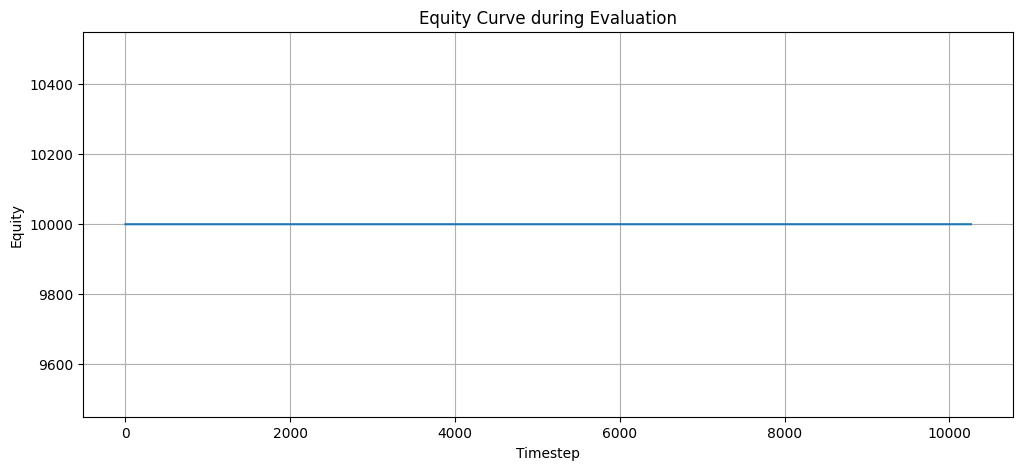

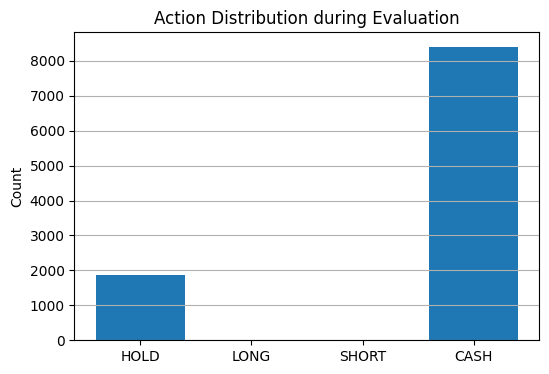

In [26]:
from typing import Counter


plt.figure(figsize=(12, 5))
plt.plot(equity_curve)
plt.title("Equity Curve during Evaluation")
plt.xlabel("Timestep")
plt.ylabel("Equity")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
action_counts = Counter(actions)
labels = ['HOLD', 'LONG', 'SHORT', 'CASH']
values = [action_counts.get(i, 0) for i in range(4)]
plt.bar(labels, values)
plt.title("Action Distribution during Evaluation")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()